### Import all required Modules

In [2]:
#all imports
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from datetime import datetime
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from statsmodels import robust
from scipy.stats import *
from tqdm import tqdm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import zipfile
import os
from scipy import fftpack

### Reading data CSV

In [3]:
#reading data
data=pd.read_csv("X_train.csv")
c=list(data.columns)
y=list(pd.read_csv("y_train.csv")['surface'])

#encoding labels
le = preprocessing.LabelEncoder()
le.fit(y)
unique_labels=le.classes_
encoded_y=le.transform(y)

# printing encoded label dictionary
le_class_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_class_mapping)

{'carpet': 0, 'concrete': 1, 'fine_concrete': 2, 'hard_tiles': 3, 'hard_tiles_large_space': 4, 'soft_pvc': 5, 'soft_tiles': 6, 'tiled': 7, 'wood': 8}


### Statistical Feature extraction

In [4]:
# Engineeried features >>> [mean ,median, variance, std, maximum, minimum, 
#                           iqr, cov, skew, kurtosis, mad] of each signals

#function to extract statistical features 
def feature_extract(ar):
    mean=np.mean(ar)
    median=np.median(ar)
    variance=np.var(ar)
    std=np.std(ar)
    maximum=np.max(ar)
    minimum=np.min(ar)
    iqr=stats.iqr(ar)
    cov=stats.variation(ar)
    skew=stats.skew(ar)
    kurtosis=stats.kurtosis(ar)
    mad=robust.mad(ar)
    return [mean,median,variance,std,maximum,minimum,iqr,cov,skew,kurtosis,mad]

# preparing training data
final_feat=[]
for i in range(0,3810):
    df=data[(i*128):(i*128)+128]
    feat=[]
    for k in c[3:]:
        fe=feature_extract(df[k].to_numpy())
        for j in fe:
            feat.append(j)
    final_feat.append(feat)
    
#final data array
final_feat_array=np.array(final_feat)



### Fourier Feature Extraction

In [5]:
# Reshaping data to feature extration 
X_train_data = pd.read_csv("X_train.csv")
def dataset_for_nn(X_dataset):
    num_samples = X_dataset.shape[0]//128
    X_dataset_for_nn = np.zeros((num_samples,128,10))
    for i in range(num_samples):
        subset = np.array(X_dataset.iloc[i*128:(i+1)*128,3:])
        X_dataset_for_nn[i,:,:] = subset
    return X_dataset_for_nn

X_train_for_nn = dataset_for_nn(X_train_data)

# computing fourier transform features of the data
def freqs(dataset,width):
    X = np.abs(fftpack.fft(dataset))
    squeezed_dataset = []
    for i in range(64//width):
        squeezed_dataset.append(np.mean(X[i*width:(i+1)*width]))
    return squeezed_dataset

# function to extract features
def X_features(X_dataset,width=3):
    num_samples = len(list(set(X_dataset["series_id"])))
    num_cols = 64//width
    features = np.zeros((num_samples,110+10*num_cols))
    for i in range(num_samples):
        X_train_subset = np.array(X_dataset.iloc[i*128:(i+1)*128,3:])
        for j in range(X_train_subset.shape[1]):
            features[i,110+j*num_cols:110+(j+1)*num_cols] = freqs(X_train_subset[:,j],width)
    return features

X_train_features = X_features(X_train_data)

In [6]:
# Merge statistical features and fourier transform features
for i in range(final_feat_array.shape[0]):
    for j in range(final_feat_array.shape[1]):
        X_train_features[i][j]=final_feat_array[i][j]

In [7]:
# perform train test split and standardization
X_train, X_test, y_train, y_test = train_test_split(X_train_features, encoded_y, test_size=0.3, random_state=42,stratify=encoded_y)
std_scale = StandardScaler().fit(X_train)
X_train = std_scale.transform(X_train)
X_test = std_scale.transform(X_test)

In [5]:
# printing size of train test data
print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))

X_train and y_train : ((2667, 320),(2667,))
X_test  and y_test  : ((1143, 320),(1143,))


# Let's model with our data

### Labels that are useful in plotting confusion matrix

In [92]:
# unique_labels 
labels=list(unique_labels)
print(labels)

['carpet', 'concrete', 'fine_concrete', 'hard_tiles', 'hard_tiles_large_space', 'soft_pvc', 'soft_tiles', 'tiled', 'wood']


### Function to plot the confusion matrix

In [8]:
# function confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Generic function to run any model specified

In [9]:
# general function to run any model
def perform_model(model, X_train, y_train, X_test, y_test, class_labels, cm_normalize=True, \
                 print_cm=True, cm_cmap=plt.cm.Greens):
    
    
    # to store results at various phases
    results = dict()
    
    # time at which model starts training 
    train_start_time = datetime.now()
    print('training the model..')
    model.fit(X_train, y_train)
    print('Done \n \n')
    train_end_time = datetime.now()
    results['training_time'] =  train_end_time - train_start_time
    print('training_time(HH:MM:SS.ms) - {}\n\n'.format(results['training_time']))
    
    
    # predict test data
    print('Predicting test data')
    test_start_time = datetime.now()
    y_pred = model.predict(X_test)
    test_end_time = datetime.now()
    print('Done \n \n')
    results['testing_time'] = test_end_time - test_start_time
    print('testing time(HH:MM:SS:ms) - {}\n\n'.format(results['testing_time']))
    results['predicted'] = y_pred
   

    # calculate overall accuracty of the model
    accuracy = metrics.accuracy_score(y_true=y_test, y_pred=y_pred)
    
    # store accuracy in results
    results['accuracy'] = accuracy
    print('---------------------')
    print('|      Accuracy      |')
    print('---------------------')
    print('\n    {}\n\n'.format(accuracy))
    
    
    # confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    results['confusion_matrix'] = cm
    if print_cm: 
        print('--------------------')
        print('| Confusion Matrix |')
        print('--------------------')
        print('\n {}'.format(cm))
        
    # plot confusin matrix
    plt.figure(figsize=(8.1,8.1))
    plt.grid(b=False)
    plot_confusion_matrix(cm, classes=class_labels, normalize=True, title='Normalized confusion matrix', cmap = cm_cmap)
    plt.show()
    
    # get classification report
    print('-------------------------')
    print('| Classifiction Report |')
    print('-------------------------')
    classification_report = metrics.classification_report(y_test, y_pred)
    
    # store report in results
    results['classification_report'] = classification_report
    print(classification_report)
    
    # add the trained  model to the results
    results['model'] = model
    
    return results
    
    

### Method to print the gridsearch Attributes

In [10]:
# printing methods
def print_grid_search_attributes(model):
    # Estimator that gave highest score among all the estimators formed in GridSearch
    print('--------------------------')
    print('|      Best Estimator     |')
    print('--------------------------')
    print('\n\t{}\n'.format(model.best_estimator_))

    # parameters that gave best results while performing grid search
    print('--------------------------')
    print('|     Best parameters     |')
    print('--------------------------')
    print('\tParameters of best estimator : \n\n\t{}\n'.format(model.best_params_))

    #  number of cross validation splits
    print('---------------------------------')
    print('|   No of CrossValidation sets   |')
    print('--------------------------------')
    print('\n\tTotal numbre of cross validation sets: {}\n'.format(model.n_splits_))

    # Average cross validated score of the best estimator, from the Grid Search 
    print('--------------------------')
    print('|        Best Score       |')
    print('--------------------------')
    print('\n\tAverage Cross Validate scores of best estimator : \n\n\t{}\n'.format(model.best_score_))   

# 1. Logistic Regression with Grid Search

training the model..
Fitting 4 folds for each of 18 candidates, totalling 72 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done  72 out of  72 | elapsed: 65.5min finished


Done 
 

training_time(HH:MM:SS.ms) - 1:06:06.618887


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.005001


---------------------
|      Accuracy      |
---------------------

    0.6500437445319335


--------------------
| Confusion Matrix |
--------------------

 [[ 21   6   4   0  10   8   1   0   7]
 [  4 157  11   0   9  19   0  12  22]
 [  1  10  47   0   3  12   1   7  28]
 [  0   0   0   0   0   4   0   0   2]
 [  0  15   3   0  50   1   2  18   3]
 [  3   8  11   0   0 182   7   0   9]
 [  2   0   0   0   0   5  81   0   1]
 [  3  14   5   0   2  13   5  96  16]
 [  4  13   8   0   3  23   5  17 109]]


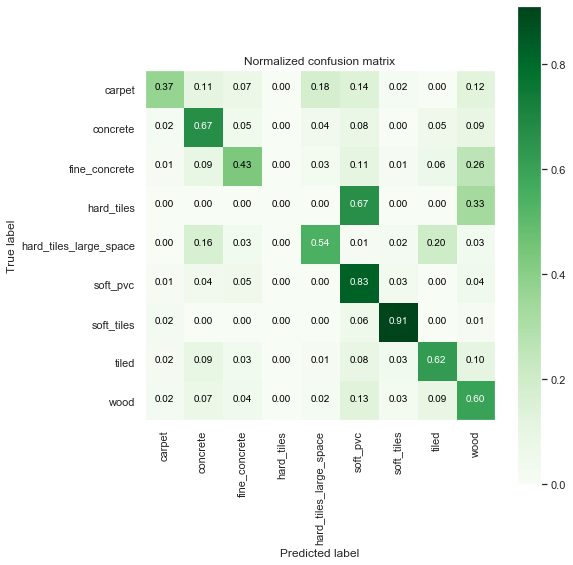

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.55      0.37      0.44        57
           1       0.70      0.67      0.69       234
           2       0.53      0.43      0.47       109
           3       0.00      0.00      0.00         6
           4       0.65      0.54      0.59        92
           5       0.68      0.83      0.75       220
           6       0.79      0.91      0.85        89
           7       0.64      0.62      0.63       154
           8       0.55      0.60      0.58       182

    accuracy                           0.65      1143
   macro avg       0.57      0.55      0.56      1143
weighted avg       0.64      0.65      0.64      1143



In [10]:
# start Grid search
import warnings
warnings.filterwarnings('ignore')
from sklearn import linear_model
parameters = {'C':[0.0001,0.001,0.01, 0.1, 1, 10, 100, 1000,10000], 'penalty':['l2','l1']}
log_reg = linear_model.LogisticRegression()
log_reg_grid = GridSearchCV(log_reg, param_grid=parameters, cv=4, verbose=1, n_jobs=6)
log_reg_grid_results =  perform_model(log_reg_grid, X_train, y_train, X_test, y_test,class_labels=labels)

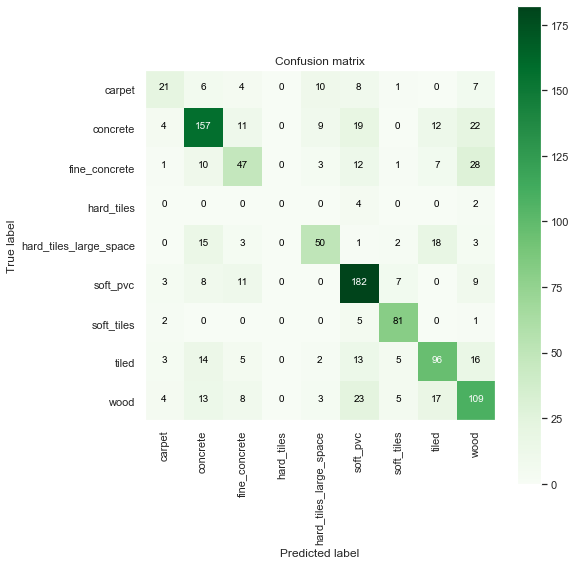

In [11]:
# plot confusion matrix
plt.figure(figsize=(8.1,8.1))
plt.grid(b=False)
plot_confusion_matrix(log_reg_grid_results['confusion_matrix'], classes=labels, cmap=plt.cm.Greens, )
plt.show()

In [12]:
# attributes of the model 
print_grid_search_attributes(log_reg_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 1, 'penalty': 'l1'}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 4

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.6261717285339332



#  2. Linear SVC with GridSearch

training the model..
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  36 out of  36 | elapsed:  2.0min finished


Done 
 

training_time(HH:MM:SS.ms) - 0:02:13.765057


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.009003


---------------------
|      Accuracy      |
---------------------

    0.6482939632545932


--------------------
| Confusion Matrix |
--------------------

 [[ 25   5   5   0   7   8   1   0   6]
 [  5 146  12   0  14  16   1  15  25]
 [  1  14  50   4   6   6   0   6  22]
 [  0   0   0   1   0   3   1   0   1]
 [  0  11   4   0  53   0   3  17   4]
 [  4   8  13   0   2 180   4   0   9]
 [  1   0   1   0   0   2  85   0   0]
 [  6  13   3   1   5  12   5  95  14]
 [  4  19   7   0   5  20   4  17 106]]


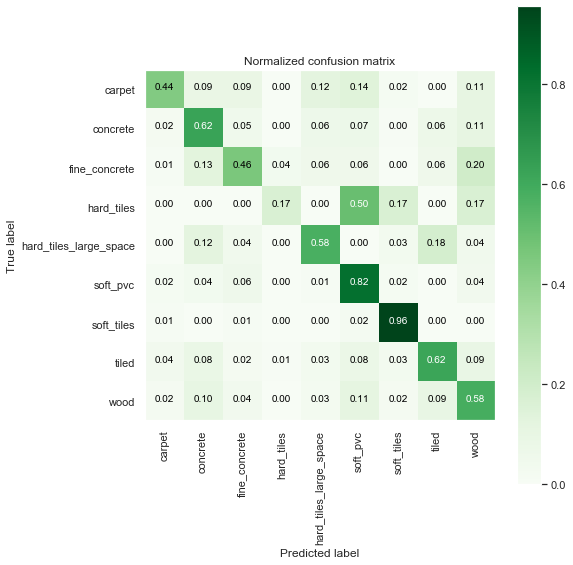

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.54      0.44      0.49        57
           1       0.68      0.62      0.65       234
           2       0.53      0.46      0.49       109
           3       0.17      0.17      0.17         6
           4       0.58      0.58      0.58        92
           5       0.73      0.82      0.77       220
           6       0.82      0.96      0.88        89
           7       0.63      0.62      0.62       154
           8       0.57      0.58      0.57       182

    accuracy                           0.65      1143
   macro avg       0.58      0.58      0.58      1143
weighted avg       0.64      0.65      0.64      1143



In [13]:
from sklearn.svm import LinearSVC
parameters = {'C':[0.001,0.01,0.125, 0.5, 1, 2, 8, 20,100]}
lr_svc = LinearSVC()
lr_svc_grid = GridSearchCV(lr_svc, param_grid=parameters, n_jobs=6, verbose=1,cv=4)
lr_svc_grid_results = perform_model(lr_svc_grid, X_train, y_train, X_test, y_test, class_labels=labels)

In [14]:
print_grid_search_attributes(lr_svc_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	LinearSVC(C=0.5, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=5e-05,
          verbose=0)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 0.5}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 4

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.6115485564304461



# 3.  Kernel SVM with GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:14:26.272031


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.997072


---------------------
|      Accuracy      |
---------------------

    0.7847769028871391


--------------------
| Confusion Matrix |
--------------------

 [[ 36  12   1   0   1   4   2   1   0]
 [  5 205   8   0   1   3   0   6   6]
 [  3  15  65   0   5   6   0   8   7]
 [  0   0   0   5   0   0   0   0   1]
 [  3  14   4   0  67   1   0   2   1]
 [  0   9   7   1   2 192   2   0   7]
 [  1   2   1   2   0   4  79   0   0]
 [  4  19   2   0   0   5   3 115   6]
 [  2  22   7   0   0  10   0   8 133]]


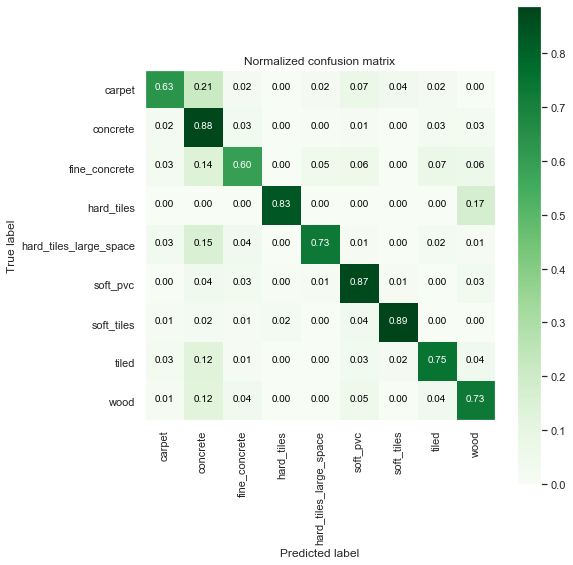

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.67      0.63      0.65        57
           1       0.69      0.88      0.77       234
           2       0.68      0.60      0.64       109
           3       0.62      0.83      0.71         6
           4       0.88      0.73      0.80        92
           5       0.85      0.87      0.86       220
           6       0.92      0.89      0.90        89
           7       0.82      0.75      0.78       154
           8       0.83      0.73      0.78       182

    accuracy                           0.78      1143
   macro avg       0.77      0.77      0.77      1143
weighted avg       0.79      0.78      0.78      1143



In [15]:
from sklearn.svm import SVC
parameters = {'C':[0.001, 0.01, 0.1,1,2,8,20,100],'gamma': [0.001,0.0078,0.01,0.125,1,2,8,10,15,20,25,30,40,100]}
rbf_svm = SVC(kernel='rbf')
rbf_svm_grid = GridSearchCV(rbf_svm,param_grid=parameters, n_jobs=6,cv=4)
rbf_svm_grid_results = perform_model(rbf_svm_grid, X_train, y_train, X_test, y_test, class_labels=labels)

In [16]:
print_grid_search_attributes(rbf_svm_grid_results['model'])

--------------------------
|      Best Estimator     |
--------------------------

	SVC(C=20, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0078, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

--------------------------
|     Best parameters     |
--------------------------
	Parameters of best estimator : 

	{'C': 20, 'gamma': 0.0078}

---------------------------------
|   No of CrossValidation sets   |
--------------------------------

	Total numbre of cross validation sets: 4

--------------------------
|        Best Score       |
--------------------------

	Average Cross Validate scores of best estimator : 

	0.7769028871391076



# 4. Decision Trees with GridSearchCV

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:00:43.293242


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.002002


---------------------
|      Accuracy      |
---------------------

    0.7060367454068242


--------------------
| Confusion Matrix |
--------------------

 [[ 32   4   6   1   0  11   2   0   1]
 [  7 193   7   0   3  12   0   2  10]
 [  2  16  55   0   4  17   1   8   6]
 [  0   0   1   1   0   3   0   0   1]
 [  0  12   9   0  69   0   1   1   0]
 [  4   4   3   1   1 179   8   0  20]
 [  4   3   2   1   2   5  71   1   0]
 [  2  24   3   1   2   9   3  99  11]
 [  9  22   8   3   2  15   6   9 108]]


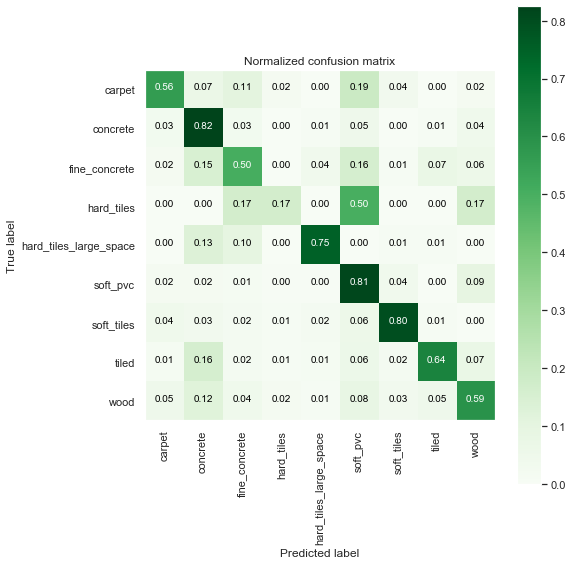

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.53      0.56      0.55        57
           1       0.69      0.82      0.75       234
           2       0.59      0.50      0.54       109
           3       0.12      0.17      0.14         6
           4       0.83      0.75      0.79        92
           5       0.71      0.81      0.76       220
           6       0.77      0.80      0.78        89
           7       0.82      0.64      0.72       154
           8       0.69      0.59      0.64       182

    accuracy                           0.71      1143
   macro avg       0.64      0.63      0.63      1143
weighted avg       0.71      0.71      0.70      1143

--------------------------
|      Best Estimator     |
--------------------------

	DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                       max_features=None, max_leaf_nodes=None

In [17]:
from sklearn.tree import DecisionTreeClassifier
parameters = {'max_depth': [3,5,7,9,12,24,28,30,35,40],'min_samples_split': [2,3,5,7,9,12,24,50]}
dt = DecisionTreeClassifier()
dt_grid = GridSearchCV(dt,param_grid=parameters, n_jobs=8,cv=4)
dt_grid_results = perform_model(dt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(dt_grid_results['model'])

# 5. Random Forest Classifier with GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 2:11:57.085331


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.340023


---------------------
|      Accuracy      |
---------------------

    0.8381452318460193


--------------------
| Confusion Matrix |
--------------------

 [[ 45   4   0   0   0   4   0   1   3]
 [  1 210   2   0   4   5   2   2   8]
 [  0  11  68   0   3   5   5  10   7]
 [  0   0   0   0   0   3   0   0   3]
 [  1   5   2   0  79   1   2   0   2]
 [  0   4   1   0   2 209   0   0   4]
 [  0   0   0   0   0   2  85   0   2]
 [  1  15   0   0   0   7   5 124   2]
 [  1  12   4   0   0  15   1  11 138]]


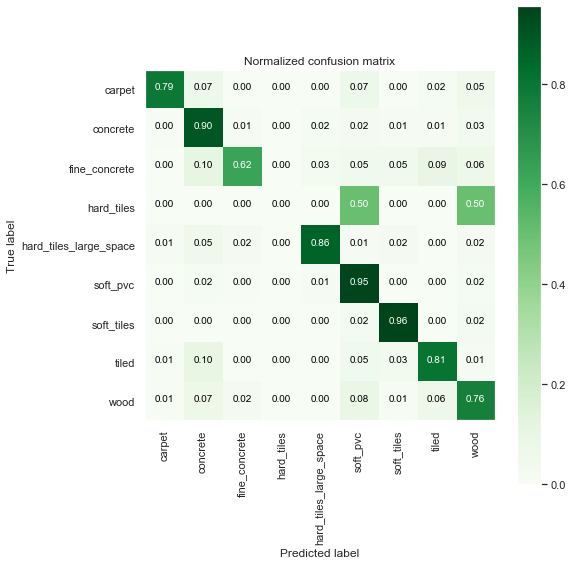

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.92      0.79      0.85        57
           1       0.80      0.90      0.85       234
           2       0.88      0.62      0.73       109
           3       0.00      0.00      0.00         6
           4       0.90      0.86      0.88        92
           5       0.83      0.95      0.89       220
           6       0.85      0.96      0.90        89
           7       0.84      0.81      0.82       154
           8       0.82      0.76      0.79       182

    accuracy                           0.84      1143
   macro avg       0.76      0.74      0.74      1143
weighted avg       0.84      0.84      0.83      1143

--------------------------
|      Best Estimator     |
--------------------------

	RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', 

In [18]:
from sklearn.ensemble import RandomForestClassifier
params = {
'n_estimators' : [200, 700, 800, 1000, 1200],
'max_depth' : [15, 20, 25, 30, 35, 50],
'min_samples_split' : [2, 3, 5, 8],
'min_samples_leaf' : [1, 2, 5, 10] }
rfc = RandomForestClassifier()
rfc_grid = GridSearchCV(rfc, param_grid=params, n_jobs=6,cv=4)
rfc_grid_results = perform_model(rfc_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(rfc_grid_results['model'])

# 6.  Gradient Boosted Decision Trees With GridSearch

training the model..
Done 
 

training_time(HH:MM:SS.ms) - 0:13:59.628789


Predicting test data
Done 
 

testing time(HH:MM:SS:ms) - 0:00:00.047014


---------------------
|      Accuracy      |
---------------------

    0.8600174978127734


--------------------
| Confusion Matrix |
--------------------

 [[ 46   3   1   0   2   2   0   1   2]
 [  1 213   0   0   2   4   1   6   7]
 [  0   9  72   0   1   6   2   6  13]
 [  0   0   0   0   0   1   0   0   5]
 [  1   7   1   1  80   0   1   0   1]
 [  0   4   3   0   1 205   1   0   6]
 [  1   2   0   0   0   2  83   0   1]
 [  2  11   0   0   1   7   2 129   2]
 [  2   6   4   1   0   6   0   8 155]]


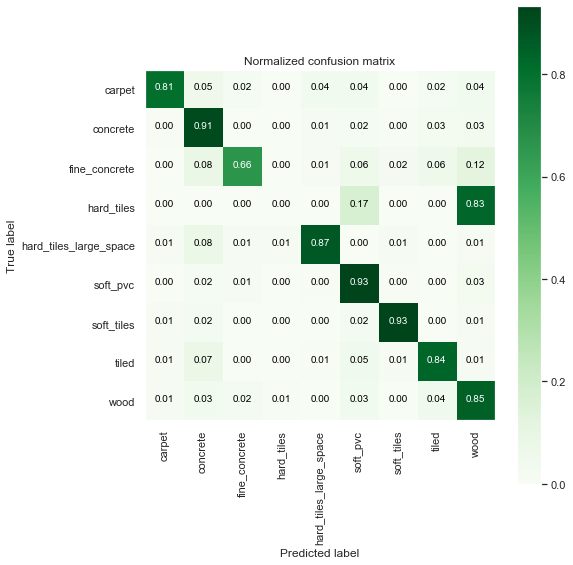

-------------------------
| Classifiction Report |
-------------------------
              precision    recall  f1-score   support

           0       0.87      0.81      0.84        57
           1       0.84      0.91      0.87       234
           2       0.89      0.66      0.76       109
           3       0.00      0.00      0.00         6
           4       0.92      0.87      0.89        92
           5       0.88      0.93      0.91       220
           6       0.92      0.93      0.93        89
           7       0.86      0.84      0.85       154
           8       0.81      0.85      0.83       182

    accuracy                           0.86      1143
   macro avg       0.78      0.76      0.76      1143
weighted avg       0.86      0.86      0.86      1143

--------------------------
|      Best Estimator     |
--------------------------

	GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_dep

In [19]:
from sklearn.ensemble import GradientBoostingClassifier
param_grid = {'max_depth': [2,5,6,8,10],'n_estimators':[120,160,200,250,300,400]}
gbdt = GradientBoostingClassifier()
gbdt_grid = GridSearchCV(gbdt, param_grid=param_grid, n_jobs=-1,cv=4)
gbdt_grid_results = perform_model(gbdt_grid, X_train, y_train, X_test, y_test, class_labels=labels)
print_grid_search_attributes(gbdt_grid_results['model'])

# 7.  XG-Boost  With RandomizedSearch

In [20]:
from scipy.stats import randint as sp_randint
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
clf = xgb.XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss')
param_grid = {
'max_depth': sp_randint(3, 20),
'learning_rate': [0.001, 0.01, 0.1, 0.2, 0,3],
'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
'eta': [0.02,0.1,0.4, 0.5, 0.6, 0.7, 0.8,0.9,1],
'min_child_weight': [0.25,0.5, 1.0, 3.0, 5.0, 7.0],
'gamma': [0, 0.25, 0.3,0.35,0.45,0.5,0.6,0.8,1.0],
'reg_lambda': [0.1,0.2,0.4,0.5,0.6,0.8,1.0,10.0],
'n_estimators': sp_randint(100,400)
}
rs_clf = RandomizedSearchCV(clf, param_grid,n_jobs=3,verbose=1,scoring='accuracy', random_state=1)
print("Randomized search..")
rs_clf.fit(X_train, y_train)
best_score = rs_clf.best_score_
best_params = rs_clf.best_params_
print("Best score: {}".format(np.abs(best_score)))

Randomized search..
Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  30 out of  30 | elapsed: 68.4min finished


Best score: 0.8353955755530559


In [22]:
print("Best K-Fold score: {}".format(best_score))
print(" Best params: ")
for param_name in sorted(best_params.keys()):
    print('%s: %r' % (param_name, best_params[param_name]))

Best K-Fold score: 0.8353955755530559
 Best params: 
eta: 0.9
gamma: 0.6
learning_rate: 0.01
max_depth: 8
min_child_weight: 1.0
n_estimators: 352
reg_lambda: 0.4
subsample: 0.9


In [11]:
from scipy.stats import randint as sp_randint
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
print("Xg-Boost..")
clf = xgb.XGBClassifier(objective='multi:softmax',eval_metric= 'mlogloss',eta=0.9,gamma=0.6,learning_rate=0.01,max_depth=8,
                        min_child_weight=1.0,n_estimators=352,reg_lambda=0.4,subsample=0.9,n_jobs=3,num_class=9)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print("The test score is:",accuracy_score(y_test,pred))

Xg-Boost..
The test score is: 0.8433945756780402



# 7. Comparing all models

In [104]:
print('\n                     Accuracy     Error')
print('                     ----------   --------')
print('Logistic Regression : {:.04}%       {:.04}%'.format(log_reg_grid_results['accuracy'] * 100,\
                                                  100-(log_reg_grid_results['accuracy'] * 100)))

print('Linear SVC          : {:.04}%       {:.04}% '.format(lr_svc_grid_results['accuracy'] * 100,\
                                                        100-(lr_svc_grid_results['accuracy'] * 100)))

print('rbf SVM classifier  : {:.04}%      {:.04}% '.format(rbf_svm_grid_results['accuracy'] * 100,\
                                                          100-(rbf_svm_grid_results['accuracy'] * 100)))

print('DecisionTree        : {:.04}%      {:.04}% '.format(dt_grid_results['accuracy'] * 100,\
                                                        100-(dt_grid_results['accuracy'] * 100)))

print('Random Forest       : {:.04}%      {:.04}% '.format(rfc_grid_results['accuracy'] * 100,\
                                                           100-(rfc_grid_results['accuracy'] * 100)))
print('GradientBoosting DT : {:.04}%      {:.04}% '.format(gbdt_grid_results['accuracy'] * 100,\
                                                        100-(gbdt_grid_results['accuracy'] * 100)))
print("Xgboost classifier  : 84.33%      15.67% ")


                     Accuracy     Error
                     ----------   --------
Logistic Regression : 65.00%      35.00%
Linear SVC          : 64.83%      35.17% 
RBF SVM Classifier  : 78.48%      21.52% 
DecisionTree        : 70.60%      29.40% 
Random Forest       : 83.81%      16.19% 
GradientBoosting DT : 86.00%      14.00% 
Xg-Boost classifier : 84.33%      15.67% 


> We can choose ___GradientBoosting DT___ or ___Xg-Boost classifier___ or ___Random Forest___ for Production

<h2>Conclusion :</h2>

* In the real world, domain-knowledge, EDA and feature-engineering matter most.
* the Ensembles based models perform well on data with GradientBoosting-DT an high Score of 86.00%.
* The Linear models don't perform well on the Test data.
* The RBF-SVM-classifier has an decent score of 78.48%.